# Building Network Models

@[Xiaoyu Chen](mailto:c-xy17@tsinghua.org.cn) @[Chaoming Wang](https://github.com/chaoming0625)

In previous sections, it has been illustrated how to define neuron models by `brainpy.NeuGroup` and synapse models by `brainpy.TwoEndConn`. This section will introduce `brainpy.Network`, which is the base class used to build network models.

In essence, [brainpy.Network](../apis/auto/building/generated/brainpy.building.brainobjects.Network.rst) is a container, whose function is to compose the individual elements. It is a subclass of a more general class: [brainpy.Container](../apis/auto/building/generated/brainpy.building.brainobjects.Container.rst). 

In below, we take an excitation-inhibition (E-I) balanced network model as an example to illustrate how to compose the [LIF neurons](./neuron_models.ipynb) and [Exponential synapses](./synapse_models.ipynb) defined in previous tutorials to build a network. 

In [1]:
import brainpy as bp

bp.math.set_platform('cpu')

## Excitation-Inhibition (E-I) Balanced Network

The E-I balanced network was first proposed to explain the irregular firing patterns of cortical neurons and comfirmed by experimental data. The network [1] we are going to implement consists of excitatory (E) neurons and inhibitory (I) neurons, the ratio of which is about 4 : 1. The biggest difference between excitatory and inhibitory neurons is the reversal potential - the reversal potential of inhibitory neurons is much lower than that of excitatory neurons. Besides, the membrane time constant of inhibitory neurons is longer than that of excitatory neurons, which indicates that inhibitory neurons have slower dynamics.

[1] Brette, R., Rudolph, M., Carnevale, T., Hines, M., Beeman, D., Bower, J. M., et al. (2007), Simulation of networks of spiking neurons: a review of tools and strategies., J. Comput. Neurosci., 23, 3, 349–98.

In [2]:
# BrianPy has some built-in conanical neuron and synapse models

LIF = bp.models.LIF
ExpCOBA = bp.models.ExpCOBA

## Two ways to define network models

There are several ways to define a Network model. 

### 1. Defining a network as a class

The first way to define a network model is like follows. 

In [3]:
class EINet(bp.Network):
  def __init__(self, num_exc, num_inh, method='exp_auto', **kwargs):
    super(EINet, self).__init__(**kwargs)

    # neurons
    pars = dict(V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5.)
    E = LIF(num_exc, **pars, method=method)
    I = LIF(num_inh, **pars, method=method)
    E.V.value = bp.math.random.randn(num_exc) * 2 - 55.
    I.V.value = bp.math.random.randn(num_inh) * 2 - 55.

    # synapses
    w_e = 0.6  # excitatory synaptic weight
    w_i = 6.7  # inhibitory synaptic weight
    E_pars = dict(E=0., g_max=w_e, tau=5.)
    I_pars = dict(E=-80., g_max=w_i, tau=10.)
    
    # Neurons connect to each other randomly with a connection probability of 2%
    self.E2E = ExpCOBA(E, E, bp.conn.FixedProb(prob=0.02), **E_pars, method=method)
    self.E2I = ExpCOBA(E, I, bp.conn.FixedProb(prob=0.02), **E_pars, method=method)
    self.I2E = ExpCOBA(I, E, bp.conn.FixedProb(prob=0.02), **I_pars, method=method)
    self.I2I = ExpCOBA(I, I, bp.conn.FixedProb(prob=0.02), **I_pars, method=method)

    self.E = E
    self.I = I

In an instance of ``brainpy.Network``,  all ``self.`` accessed elements can be gathered by the ``.child_ds()`` function automatically. 

In [4]:
EINet(8, 2).child_ds()

{'ExpCOBA0': <brainpy.building.models.synapses.ExpCOBA at 0x242ef00af70>,
 'ExpCOBA1': <brainpy.building.models.synapses.ExpCOBA at 0x242eeffc820>,
 'ExpCOBA2': <brainpy.building.models.synapses.ExpCOBA at 0x242ef0a1790>,
 'ExpCOBA3': <brainpy.building.models.synapses.ExpCOBA at 0x242eef9a4c0>,
 'LIF0': <brainpy.building.models.neurons.LIF at 0x242d0a19e50>,
 'LIF1': <brainpy.building.models.neurons.LIF at 0x242edcafc70>,
 'ConstantDelay0': <brainpy.building.brainobjects.delays.ConstantDelay at 0x242edcff820>,
 'ConstantDelay1': <brainpy.building.brainobjects.delays.ConstantDelay at 0x242eefed280>,
 'ConstantDelay2': <brainpy.building.brainobjects.delays.ConstantDelay at 0x242ef0a1880>,
 'ConstantDelay3': <brainpy.building.brainobjects.delays.ConstantDelay at 0x242eef9ae20>}

Note in the above ``EINet``, we do not define the ``update()`` function. This is because any subclass of ``brainpy.Network`` has a default update function, in which it automatically gathers the elements defined in this network and sequentially runs the update function of each element. 

If you have some special operations in your network, you can override the update function by yourself. Here is a simple example. 

In [5]:
class ExampleToOverrideUpdate(EINet):
    def update(self, _t, _dt):
        for node in self.child_ds().values():
            node.update(_t, _dt)

Let's try to simulate our defined `EINet` model. 

  0%|          | 0/1000 [00:00<?, ?it/s]

Used time 2.167832136154175 s


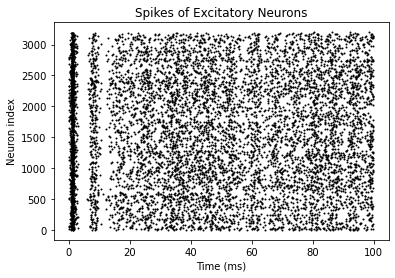

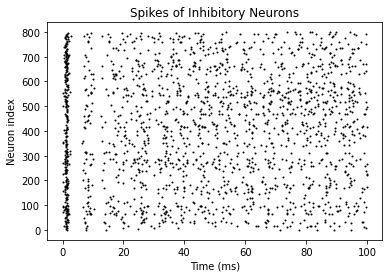

In [6]:
net = EINet(3200, 800, method='exp_auto')  # "method": the numerical integrator method

runner = bp.StructRunner(net,
                         monitors=['E.spike', 'I.spike'],
                         inputs=[('E.input', 20.), ('I.input', 20.)])
t = runner.run(100.)
print(f'Used time {t} s')

# visualization
bp.visualize.raster_plot(runner.mon.ts, runner.mon['E.spike'],
                         title='Spikes of Excitatory Neurons', show=True)
bp.visualize.raster_plot(runner.mon.ts, runner.mon['I.spike'],
                         title='Spikes of Inhibitory Neurons', show=True)

### 2. Instantiating a network directly

Another way to instantiate a network model is directly pass the elements into the constructor of ``brainpy.Network``. It receives ``*args`` and ``**kwargs`` arguments.

In [7]:
# neurons
pars = dict(V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5.)
E = LIF(3200, **pars)
I = LIF(800, **pars)
E.V.value = bp.math.random.randn(E.num) * 2 - 55.
I.V.value = bp.math.random.randn(I.num) * 2 - 55.

# synapses
E_pars = dict(E=0., g_max=0.6, tau=5.)
I_pars = dict(E=-80., g_max=6.7, tau=10.)
E2E = ExpCOBA(E, E, bp.conn.FixedProb(prob=0.02), **E_pars)
E2I = ExpCOBA(E, I, bp.conn.FixedProb(prob=0.02), **E_pars)
I2E = ExpCOBA(I, E, bp.conn.FixedProb(prob=0.02), **I_pars)
I2I = ExpCOBA(I, I, bp.conn.FixedProb(prob=0.02), **I_pars)


# Network
net2 = bp.Network(E2E, E2I, I2E, I2I, exc_group=E, inh_group=I)

 All elements are passed as ``**kwargs`` argument can be accessed by the provided keys. This will affect the following dynamics simualtion and will be discussed in greater detail in [tutorial of Monitors and Inputs](../tutorial_simulation/monitors_and_inputs.ipynb).

In [8]:
net2.exc_group

In [9]:
net2.inh_group

After construction, the simulation goes the same way:

  0%|          | 0/1000 [00:00<?, ?it/s]

Used time 0.7639970779418945 s


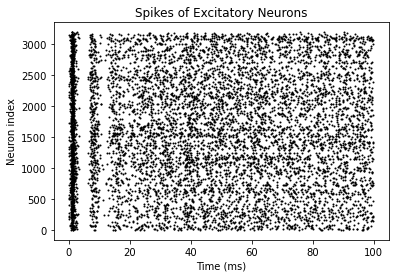

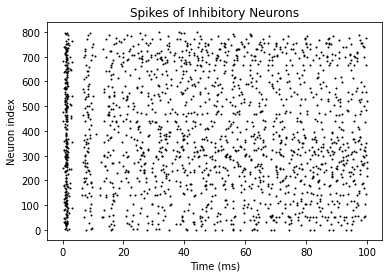

In [10]:
runner = bp.StructRunner(net2,
                         monitors=['exc_group.spike', 'inh_group.spike'],
                         inputs=[('exc_group.input', 20.), ('inh_group.input', 20.)])
t = runner.run(100.)
print(f'Used time {t} s')

# visualization
bp.visualize.raster_plot(runner.mon.ts, runner.mon['exc_group.spike'],
                         title='Spikes of Excitatory Neurons', show=True)
bp.visualize.raster_plot(runner.mon.ts, runner.mon['inh_group.spike'],
                         title='Spikes of Inhibitory Neurons', show=True)

Above are some simulation examples showing the possible application of network models. The detailed description of dynamics simulation is covered in [Dynamics Simulation](../tutorial_simulation/index.rst), where the use of monitors and inputs will be expatiated.